In [1]:
import pandas as pd
from math import sqrt
import numpy as np
import os

In [2]:
df = pd.read_csv('data/train.csv')

In [3]:
df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
dim = int(sqrt(len(df.columns)-1))
print(dim)

28


In [5]:
ix_sample = 8
sample = df.drop(columns='label').iloc[[ix_sample]].values.reshape(dim,dim)

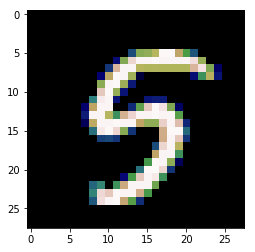

In [6]:
from PIL import Image
from matplotlib import cm
from matplotlib.pyplot import imshow
%matplotlib inline
im = Image.fromarray(np.uint8(cm.gist_earth(sample)*255))
imshow(im)

In [9]:
def indices_to_one_hot(data, nb_classes):
    """Convert an iterable of indices to one-hot encoded labels."""
    targets = np.array(data, dtype=np.int16).reshape(-1)
    return np.eye(nb_classes,dtype=np.int8)[targets]

In [11]:
from sklearn.model_selection import train_test_split
labels = df['label'].values
labels, levels = pd.factorize(labels)
classes = len(np.unique(labels))
y = indices_to_one_hot(labels, classes)
data = df.drop(columns=['label']).values
x_train, x_test, y_train, y_test = train_test_split(data,y, train_size=0.75)

In [12]:
print(len(x_train))
print(len(x_test))
print(len(y_train))
print(len(y_test))
print("classes:", classes)
print(levels)

31500
10500
31500
10500
classes: 10
[1 0 4 7 3 5 8 9 2 6]


In [13]:
print(y_train.shape)

(31500, 10)


In [14]:
### Simple NN
from keras.layers import Dense, Input
from keras.models import Model

input_shape = x_train.shape[1]
output_shape = y_train.shape[1]

inputs = Input(shape=(input_shape,))
dense1 = Dense(units=1000, activation='relu')(inputs)
dense2 = Dense(units=1000, activation='sigmoid')(dense1)
dense3 = Dense(units=1000, activation='sigmoid')(dense2)
output = Dense(units=output_shape, activation='softmax')(dense3)

model = Model(inputs=inputs, outputs=output)



c:\program files\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [15]:
from keras.optimizers import Adam

lr = 1e-4
adam = Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [16]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1000)              785000    
_________________________________________________________________
dense_2 (Dense)              (None, 1000)              1001000   
_________________________________________________________________
dense_3 (Dense)              (None, 1000)              1001000   
_________________________________________________________________
dense_4 (Dense)              (None, 10)                10010     
Total params: 2,797,010
Trainable params: 2,797,010
Non-trainable params: 0
_________________________________________________________________
None


In [17]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

EPOCHS = 100
BATCH_SIZE = 256
path = 'NN'
if not os.path.exists(path):
    os.makedirs(path)

checkpoint = ModelCheckpoint(path+'/weights.hdf5', monitor='val_acc', verbose=2, save_best_only=True, mode='auto')
early_stopping = EarlyStopping(monitor='val_loss',patience=9, verbose = 1)
reduceLR = ReduceLROnPlateau(monitor='val_loss',factor=0.33,patience=3,verbose = 1)

history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1, 
                    callbacks = [checkpoint, early_stopping, reduceLR],validation_data=(x_test, y_test), class_weight='auto')

Train on 31500 samples, validate on 10500 samples
Epoch 1/100
31500/31500 [==============================] - 4s 114us/step - loss: 0.9254 - acc: 0.7837 - val_loss: 0.3861 - val_acc: 0.9033
Epoch 2/100
31500/31500 [==============================] - 2s 53us/step - loss: 0.2981 - acc: 0.9204 - val_loss: 0.2609 - val_acc: 0.9290
Epoch 3/100
31500/31500 [==============================] - 2s 52us/step - loss: 0.2104 - acc: 0.9422 - val_loss: 0.2064 - val_acc: 0.9410
Epoch 4/100
31500/31500 [==============================] - 2s 52us/step - loss: 0.1634 - acc: 0.9553 - val_loss: 0.1774 - val_acc: 0.9493
Epoch 5/100
31500/31500 [==============================] - 2s 52us/step - loss: 0.1303 - acc: 0.9645 - val_loss: 0.1555 - val_acc: 0.9549
Epoch 6/100
31500/31500 [==============================] - 2s 52us/step - loss: 0.1048 - acc: 0.9717 - val_loss: 0.1428 - val_acc: 0.9587
Epoch 7/100
31500/31500 [==============================] - 2s 52us/step - loss: 0.0841 - acc: 0.9786 - val_loss: 0.1280 -

In [18]:
weight_file = path + '/weights.hdf5'
model.load_weights(weight_file)
y_pred = model.predict(x_test)

In [ ]:
## some visual testing

In [19]:
from sklearn.metrics import confusion_matrix, classification_report
print(confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))
print(classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))

[[1147    0    2    3    3    1    5    2    3    0]
 [   0 1044    2    0    2    3    5    0    3    1]
 [   3    1 1023    2    0    0    1    8    2    4]
 [   1    3    7 1047    1    1    2    5    5    2]
 [   4    4    0    2 1048   13   10    3    8    1]
 [   1    4    2    1   17  855    6    6    2    3]
 [   2    4    4    3   11    7  994    4    1    6]
 [   2    4   11   10    9    5    4 1032    0    1]
 [   2    1    4    8    5    0    2    1 1011    3]
 [   0    3    3    1    0    4    2    0    1 1001]]
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      1166
           1       0.98      0.98      0.98      1060
           2       0.97      0.98      0.97      1044
           3       0.97      0.97      0.97      1074
           4       0.96      0.96      0.96      1093
           5       0.96      0.95      0.96       897
           6       0.96      0.96      0.96      1036
           7       0.97      0.96   

In [ ]:
def generate_submission(model):
    